In [1]:
from convokit import Corpus, download, HyperConvo
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import json
from datetime import datetime
import pickle as pk


In [3]:
dfs = dict()

subreddit = "Christianity"
corpus = Corpus.reconnect_to_db(f'subreddit-{subreddit}')
dfs[subreddit] = df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)

subreddit = "TrueChristian"
corpus = Corpus.reconnect_to_db(f'subreddit-{subreddit}')
dfs[subreddit]  = df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)

In [4]:
speakers = dict()
for subreddit in ["Christianity", "TrueChristian"]:
    speakers[subreddit] = dfs[subreddit]['speaker'].unique()

In [167]:
common_speakers = set(speakers["Christianity"]).intersection(speakers["TrueChristian"])
common_speakers.remove("[deleted]")
common_speakers = list(common_speakers)
print(len(common_speakers))

12068


In [16]:
for subreddit in ["TrueChristian", "Christianity"]:
    df = dfs[subreddit]
    print(subreddit)
    print(df[df['speaker'].isin(common_speakers)].groupby(['speaker']).size().describe())

TrueChristian
count    12068.000000
mean        33.587753
std        166.506911
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max       5730.000000
dtype: float64
Christianity
count    12068.000000
mean       224.120815
std       1031.910221
min          1.000000
25%          4.000000
50%         17.000000
75%         78.000000
max      27546.000000
dtype: float64


In [18]:
common_speakers_utt = pd.DataFrame()
for subreddit in ["TrueChristian", "Christianity"]:
    df = dfs[subreddit]
    common_speakers_utt = pd.concat([common_speakers_utt, df[df['speaker'].isin(common_speakers)]])

In [20]:
common_speakers_utt['text_len'] = common_speakers_utt['text'].apply(lambda t: len(t.split()))

## some stats

In [21]:
common_speakers_utt.groupby(['meta.subreddit'])['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
meta.subreddit,,,,,,,,
Christianity,2704690.0,70.181515,112.102642,6.0,17.0,36.0,77.0,6846.0
TrueChristian,405337.0,87.611289,143.714178,6.0,20.0,44.0,95.0,6034.0


In [23]:
for subreddit in ["TrueChristian", "Christianity"]:
    df = dfs[subreddit]
    df['text_len'] = df['text'].apply(lambda t: len(t.split()))
    df['speaker in both TrueChristian and Christianity'] = df['speaker'].apply(lambda s: s in common_speakers)

In [26]:
pd.set_option('display.max_rows', 1000)

In [30]:
print("r/Christianity")
dfs['Christianity'].groupby(['speaker in both TrueChristian and Christianity'])['text_len'].describe()

r/Christianity


,count,mean,std,min,25%,50%,75%,max
speaker in both TrueChristian and Christianity,,,,,,,,
False,3407322.0,71.217512,109.151058,6.0,18.0,37.0,81.0,6891.0
True,2704690.0,70.181515,112.102642,6.0,17.0,36.0,77.0,6846.0


In [31]:
print("r/TrueChristian")
dfs['TrueChristian'].groupby(['speaker in both TrueChristian and Christianity'])['text_len'].describe()

r/TrueChristian


,count,mean,std,min,25%,50%,75%,max
speaker in both TrueChristian and Christianity,,,,,,,,
False,79717.0,87.839608,134.983852,6.0,20.0,45.0,101.0,4463.0
True,405337.0,87.611289,143.714178,6.0,20.0,44.0,95.0,6034.0


In [33]:
dfs['TrueChristian']['speaker'].nunique()

19547

## Longitudinal studies

In [69]:
df = dfs['TrueChristian'] 
first_utt_in_TC = df.groupby(['speaker'])['timestamp'].min()
first_utt_in_TC = first_utt_in_TC.reset_index(name='first_utt_in_TC')
first_utt_in_TC.head()

speaker
----x----          1420425164
---_-_---_-_---    1462128480
---annon---        1406663959
--Bag              1515440655
--Guardian--       1522378697
Name: timestamp, dtype: int64

### comments

In [ ]:
common_speakers_comments = common_speakers_utt[common_speakers_utt['reply_to'].notnull()].copy()

In [197]:
x = common_speakers_comments.groupby(['speaker', 'meta.subreddit']).size().reset_index(name='num_comments')
x = x.pivot(index='speaker', columns='meta.subreddit', values='num_comments')

# speakers with at least 10 posts in both subreddits
active_speakers = x[(x['Christianity'] >= 10) & (x['TrueChristian'] >= 10)].index

In [199]:
def subset_by_speakers(df, speakers):
    return df[df['speaker'].isin(speakers)].copy()

def subset_by_subreddit(df, subreddit):
    return df[df['meta.subreddit'] == subreddit].copy()

In [198]:
active_common_speakers_comments = subset_by_speakers(common_speakers_comments, active_speakers)

In [200]:
common_speakers_comments_in_Christianity = subset_by_subreddit(active_common_speakers_comments, 'Christianity')
common_speakers_comments_in_Christianity = common_speakers_comments_in_Christianity.reset_index()
print(common_speakers_comments_in_Christianity.shape)

(1808739, 22)


In [201]:
common_speakers_comments_in_Christianity = common_speakers_comments_in_Christianity.merge(first_utt_in_TC, on='speaker')
print(common_speakers_comments_in_Christianity.shape)

print(common_speakers_comments_in_Christianity['speaker'].nunique())

(1808739, 23)
3089


In [202]:
common_speakers_comments_in_Christianity['before_TC'] = common_speakers_comments_in_Christianity.apply(
    lambda row: 1 if row['timestamp'] < row['first_utt_in_TC'] else 0, axis=1)
common_speakers_comments_in_Christianity['after_TC'] = common_speakers_comments_in_Christianity.apply(
    lambda row: 1 if row['timestamp'] >= row['first_utt_in_TC'] else 0, axis=1)

In [203]:
the_group = common_speakers_comments_in_Christianity.groupby(['speaker'])
temp_df = the_group.agg({"before_TC": sum, "after_TC": sum})
temp_df['total_comments'] = the_group['id'].count()
temp_df

,before_TC,after_TC,total_comments
speaker,,,
-AveMaria-,0,39,39
-BigSexy-,172,282,454
-Firelord-Azula-,0,192,192
-GodLovesYou-,14,72,86
-Graff-,15,220,235
...,...,...,...
zimm3r16,6,146,152
zip99,21,1,22
zkkk,22,33,55


In [204]:
for K in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print(K)
    print(" ", len(temp_df[(temp_df['before_TC'] >= K) & (temp_df['after_TC'] >= K)]))

10
  1596
20
  1191
30
  974
40
  807
50
  689
60
  598
70
  555
80
  499
90
  468
100
  442


In [233]:
## text length before and after joining TC
K = 80
qualified_speakers = list(temp_df[(temp_df['before_TC'] >= K) & (temp_df['after_TC'] >= K)].index)
selected = common_speakers_comments_in_Christianity[common_speakers_comments_in_Christianity['speaker'].isin(qualified_speakers)]

In [234]:
print(selected['speaker'].nunique())

499


In [235]:
after = selected[selected['after_TC'] == 1].copy()
gr = after.sort_values(['speaker', 'timestamp']).groupby(["speaker"])
after['order'] = gr.cumcount() + 1

In [236]:
before = selected[selected['before_TC'] == 1].copy()
gr = before.sort_values(['speaker', 'timestamp'], ascending=False).groupby(['speaker'])
before['order'] = -1 * (gr.cumcount()+1)

In [237]:
## spot check 
# speaker = 'wonkifier'
# before[before['speaker'] == speaker][['id', 'timestamp', 'order']]
# after[after['speaker'] == speaker][['id', 'timestamp', 'order']]

In [238]:
dff = pd.concat([before, after])

In [239]:
import scipy.stats as st
def conf_interval(data):
    interval = st.norm.interval(confidence=0.95, loc=np.mean(data), scale=st.sem(data))
    return (interval[-1] - interval[0])/2

In [240]:
dff = dff[dff['order'].abs() <= K]
g = dff.groupby(['order']).agg({"text_len": ["mean", conf_interval]})

<AxesSubplot: xlabel='order'>

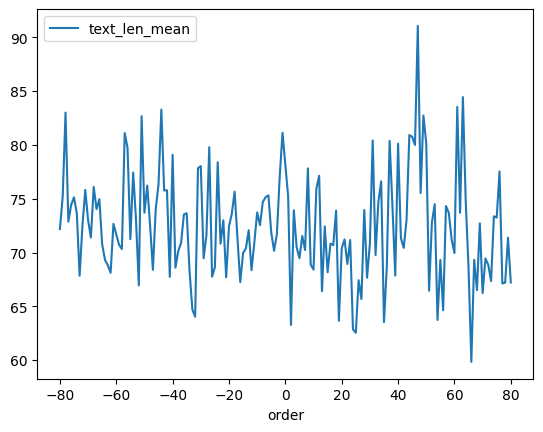

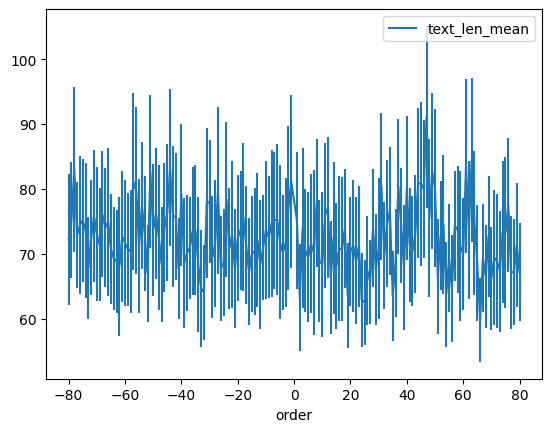

In [241]:
g.columns = g.columns.map(lambda x: '_'.join([str(i) for i in x]))
g = g.reset_index()
g.plot('order', 'text_len_mean', 
#        yerr='text_len_std',
               )
g.plot('order', 'text_len_mean', 
       yerr='text_len_conf_interval',
               )

### posts

In [171]:
common_speakers_posts = common_speakers_utt[common_speakers_utt['reply_to'].isnull()].copy()

common_speakers_posts_in_Christianity = common_speakers_posts[common_speakers_posts['meta.subreddit'] == 'Christianity'].copy()
common_speakers_posts_in_Christianity = common_speakers_posts_in_Christianity.reset_index()
print(common_speakers_posts_in_Christianity.shape)

(29626, 22)


In [172]:
common_speakers_posts_in_Christianity = common_speakers_posts_in_Christianity.merge(first_utt_in_TC, on='speaker')
print(common_speakers_posts_in_Christianity.shape)
print(common_speakers_posts_in_Christianity['speaker'].nunique())

(29626, 23)
5017


In [174]:
common_speakers_posts_in_Christianity['before_TC'] = common_speakers_posts_in_Christianity.apply(
    lambda row: 1 if row['timestamp'] < row['first_utt_in_TC'] else 0, axis=1)
common_speakers_posts_in_Christianity['after_TC'] = common_speakers_posts_in_Christianity.apply(
    lambda row: 1 if row['timestamp'] >= row['first_utt_in_TC'] else 0, axis=1)

In [176]:
the_group = common_speakers_posts_in_Christianity.groupby(['speaker'])
temp_df = the_group.agg({"before_TC": sum, "after_TC": sum})
temp_df['total_posts'] = the_group['id'].count()
temp_df

,before_TC,after_TC,total_posts
speaker,,,
---annon---,1,2,3
-4-8-15-16-23-42-,1,0,1
-AveMaria-,0,1,1
-Baljeet-Tjinder-,2,5,7
-BigSexy-,7,18,25
...,...,...,...
zombiegamer723,1,1,2
zombiemaster22,0,1,1
zphd3,1,0,1


In [177]:
for K in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print(K)
    print(" ", len(temp_df[(temp_df['before_TC'] >= K) & (temp_df['after_TC'] >= K)]))

10
  81
20
  25
30
  12
40
  8
50
  6
60
  5
70
  3
80
  3
90
  1
100
  1
